# Selección de cripto activos para una cartera de inversión

In [ ]:
#from IPython.display import Image
#Image(filename='../imagen_tapa.jpg' ,  width= 1280)

# Trabajo Práctico 5 - Aprendizaje No Supervisado

# Introducción

En finanzas, encontrar grupos de activos similares o regímenes en el comportamiento de los precios es de mucha utilidad, y es de gran ayuda en el desarrollo de filtros, definición de reglas de compra/venta, etc. 

En este práctico aplicaremos métodos de aprendizaje no supervisado. Estas metodologías en muchos casos son aplicadas antes de las de aprendizaje supervisado, dado que frecuentemente nos permiten obtener información útil de nuestros datos.

Podemos destacar métodos como clustering y reducción de dimensionalidad. Algunas de las metodologías despliegan su máximo potencial cuando se dispone de muchas series.

# ¡Actividades!

Analizaremos las variaciones (tasas de cambio) de los activos en ventanas específicas de tiempo. Nuestro objetivo será encontrar activos con comportamiento similiar en términos de sus retornos.

Para esta actividad seleccionen periodos en los cuales esté disponible la data de todos los activos. 

## Parte I - Clustering

- Aplicar el algoritmo Mean Shift. En este caso se pueden usar los criterios de información como guía para determinar la cantidad óptima de clusters.

- Aplicar k-means. Seleccionar el valor de k de acuerdo a la inercia o el análisis de siluetas.

- Aplicar un algoritmo de clustering jeráquico.

¿Encuentran grandes diferencias entre un periodo donde Bitcoin está al alza y uno donde está a la baja? 

## Parte II - Embeddings

- Aplicar el análisis de componentes principales con las tasas de rendimiento y con las tasas de rendimiento previamente estandarizadas.

En ambos casos, comenten los resultados brevemente.


# Fecha de entrega

- __Versión preliminar: 22/10__ 

- __Versión final: 29/10__

# Condiciones de entrega

Realizar un informe en el cual se presenten los resultados y conclusiones del análisis desarrollado. El mismo debe estar pensado para un público técnico pero que desconoce los aspectos propios del problema a resolver. Dicho informe puede ser un notebook, a condición de que en el mismo se efectúe un análisis escrito suficientemente detallado de los resultados. 

# Setup y variables globales

In [1]:
!pip install -q tslearn

In [2]:
from sklearn.cluster import MeanShift
from sklearn import (preprocessing, decomposition)
from sklearn.metrics import silhouette_samples, silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px


In [3]:
df_features = pd.read_parquet('https://drive.google.com/uc?id=1F7iNl24V2q1ML4KBbvSlCa1S_QieEc__')

In [4]:
df = df_features.loc[:,df_features.columns.str.contains('close_pct')]

In [5]:
# Buscamos la cripto más nueva para buscar periodos posteriores a esa fecha
newest = pd.to_datetime('1990-01-01')
for i in df.columns:
    fvi = df[i].first_valid_index()
    if fvi >= newest:
        print(f'{i}: {fvi}')
        newest = fvi

AAVEUSDT_close_pct: 2020-10-15 04:00:00


Periodo alcista
- 2021-02-01 --> 2021-02-21

Periodo bajista
- 2021-04-13 --> 2021-04-25

In [6]:
df_p1 = df.query('index >= "2021-02-01" & index <="2021-02-21"')
df_p2 = df.query('index >= "2021-04-13" & index <=" 2021-04-25"')

In [7]:
def returns(df):
    df_returns = pd.DataFrame(index=df.index)
    df_returns = df.add(1).cumprod()
    df_returns.columns = [i[:-10] for i in df_returns.columns]
    df_returns_log = np.log10(df_returns)

    return df_returns, df_returns_log

# Parte 1

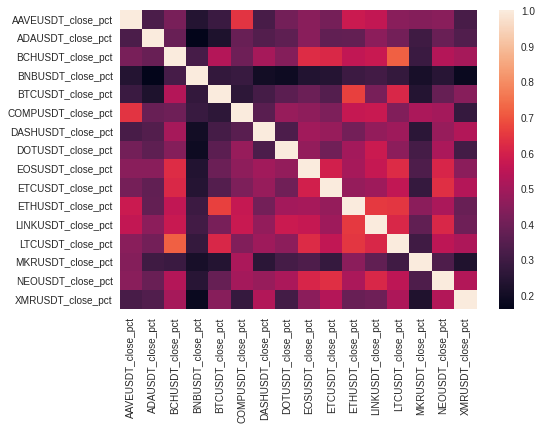

In [8]:
sns.heatmap(df_p1.corr())

P1:Podemos observar que BNB y MKR son las que menor correlación tienen con el resto de las monedas por lo que sería de esperar que se encuentren aisladas en sus clusters del resto de las monedas.

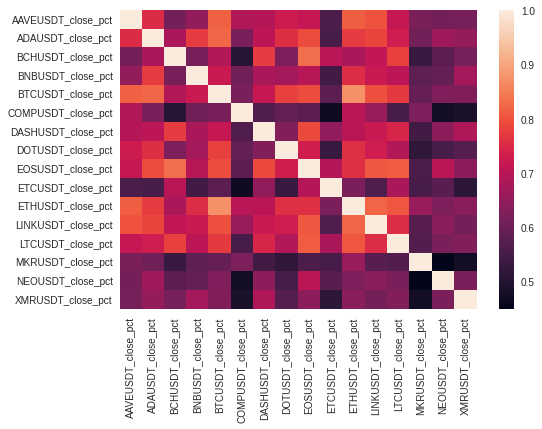

In [9]:
sns.heatmap(df_p2.corr())

P2: Podemos observaer que COMPUSDT, ETCUSDT, MKRUSDT, NEOUSDT y XMRUSDT son las que menor correlación tienen con el resto de las monedas por lo que sería de esperar que se encuentren aisladas en sus clusters o diferenciadas de algún modo.

## Mean shift

In [10]:
ms_p1_labels = MeanShift().fit_predict(df_p1.T.values)
ms_p1_labels

array([2, 3, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0])

In [11]:
ms_p2_labels = MeanShift().fit_predict(df_p2.T.values)
ms_p2_labels

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 4, 3, 0])

In [12]:
df_ms = pd.DataFrame(columns=df.columns, index=['periodo1', 'periodo2'], data=[ms_p1_labels, ms_p2_labels])
df_ms

AAVEUSDT_close_pct  ...  XMRUSDT_close_pct
periodo1                   2  ...                  0
periodo2                   0  ...                  0

[2 rows x 16 columns]

### Plot periodo 1

In [13]:
n_clusters = len(np.unique(ms_p1_labels))
print(f'Silhouette Score ({n_clusters}): {silhouette_score(df_p1.T.values, ms_p1_labels)}')

Silhouette Score (6): 0.14047928484393157


Cluster 0: ['BCHUSDT' 'BTCUSDT' 'DASHUSDT' 'DOTUSDT' 'EOSUSDT' 'ETCUSDT' 'ETHUSDT'
 'LINKUSDT' 'LTCUSDT' 'NEOUSDT' 'XMRUSDT']
Cluster 1: ['BNBUSDT']
Cluster 2: ['AAVEUSDT']
Cluster 3: ['ADAUSDT']
Cluster 4: ['MKRUSDT']
Cluster 5: ['COMPUSDT']


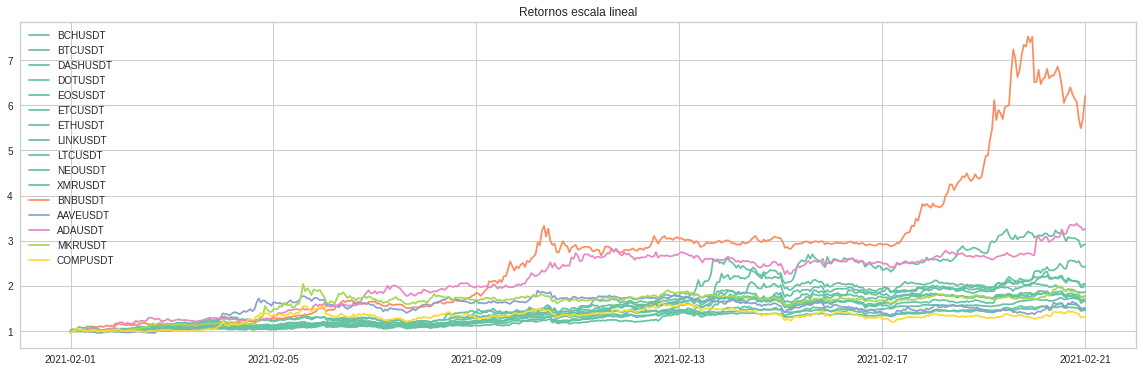

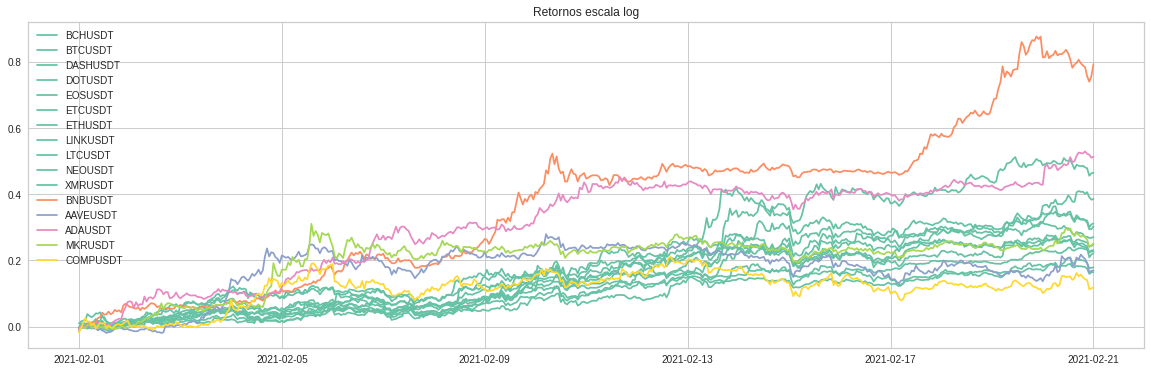

In [14]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(ms_p1_labels)):
    returns_cluster, returns_cluster_log = returns(df_p1.loc[:, df_ms.loc['periodo1'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")



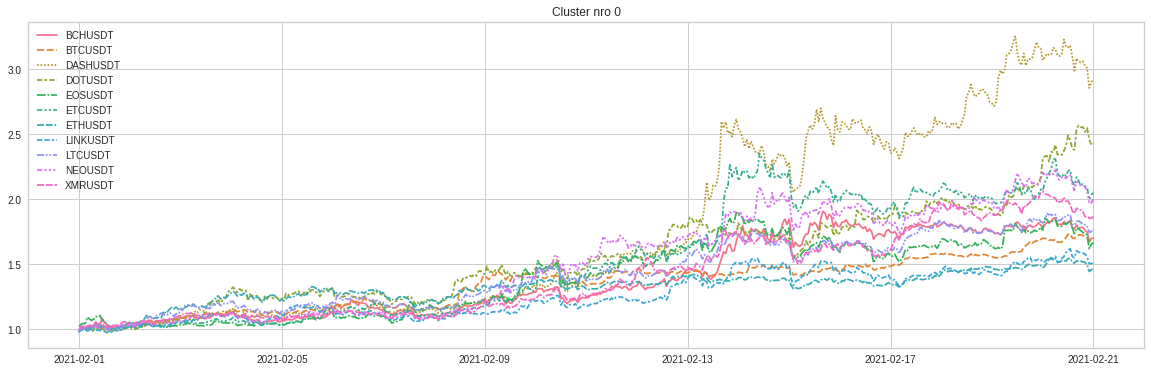

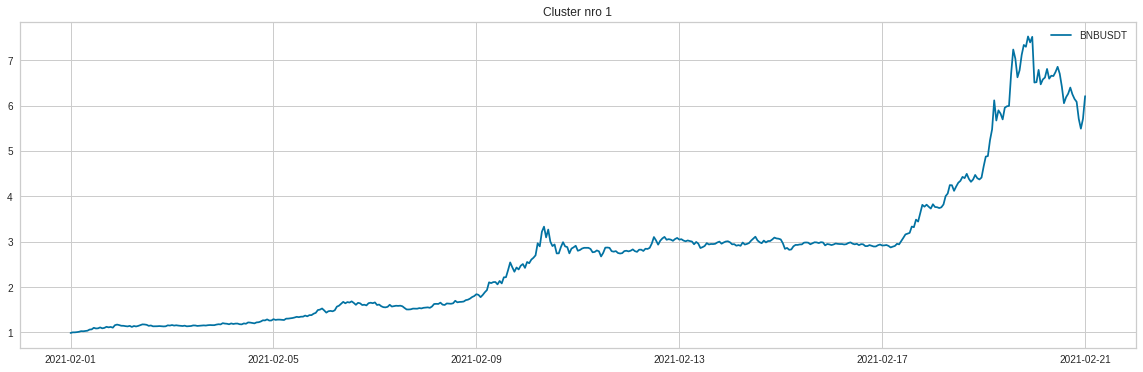

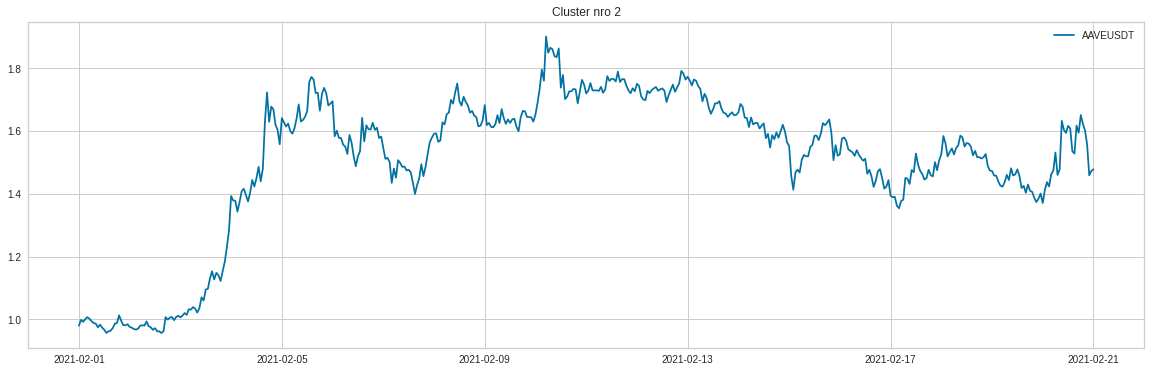

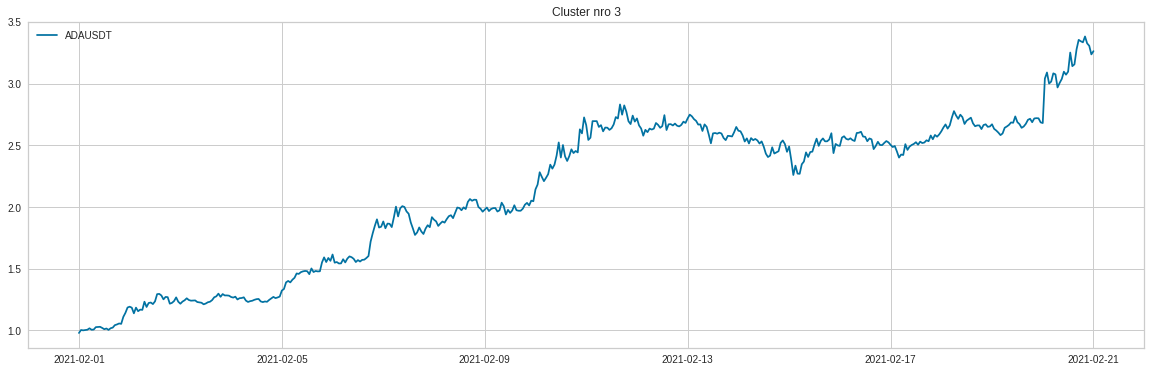

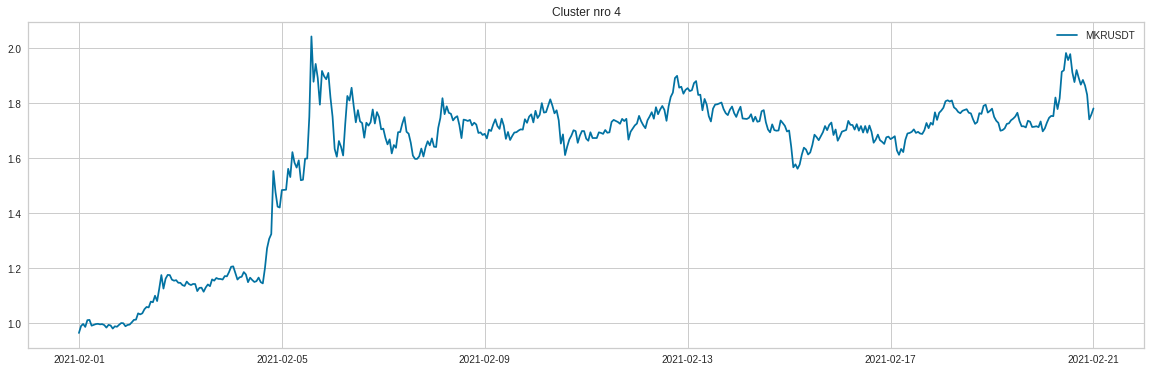

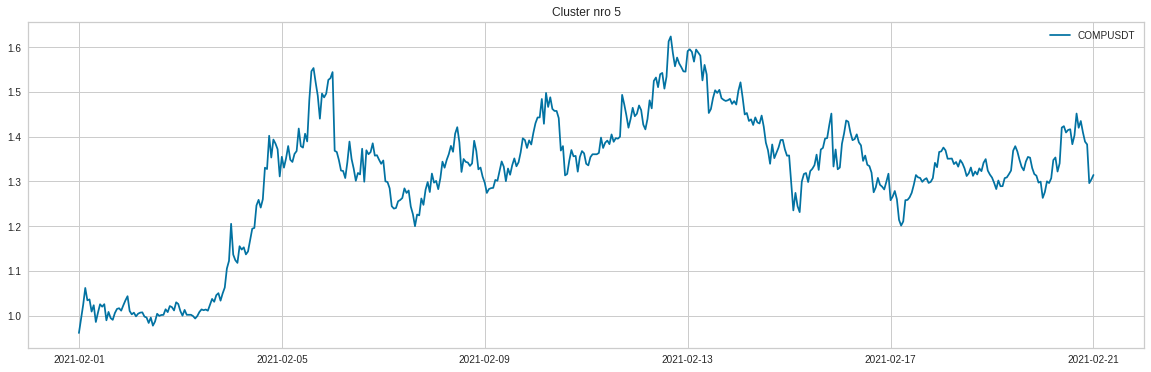

In [18]:
# Ploteamos cada cluster de forma agrupada
for c in np.unique(ms_p1_labels):
    fig = plt.figure(figsize=(20,6))
    returns_cluster,jaja = returns(df_p1.loc[:, df_ms.loc['periodo1'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

### Plot Periodo 2

In [19]:
n_clusters = len(np.unique(ms_p2_labels))
print(f'Silhouette Score ({n_clusters}): {silhouette_score(df_p2.T.values, ms_p2_labels)}')

Silhouette Score (5): 0.19100762331765037


Cluster 0: ['AAVEUSDT' 'ADAUSDT' 'BCHUSDT' 'BNBUSDT' 'BTCUSDT' 'DASHUSDT' 'DOTUSDT'
 'EOSUSDT' 'ETHUSDT' 'LINKUSDT' 'LTCUSDT' 'XMRUSDT']
Cluster 1: ['COMPUSDT']
Cluster 2: ['ETCUSDT']
Cluster 3: ['NEOUSDT']
Cluster 4: ['MKRUSDT']


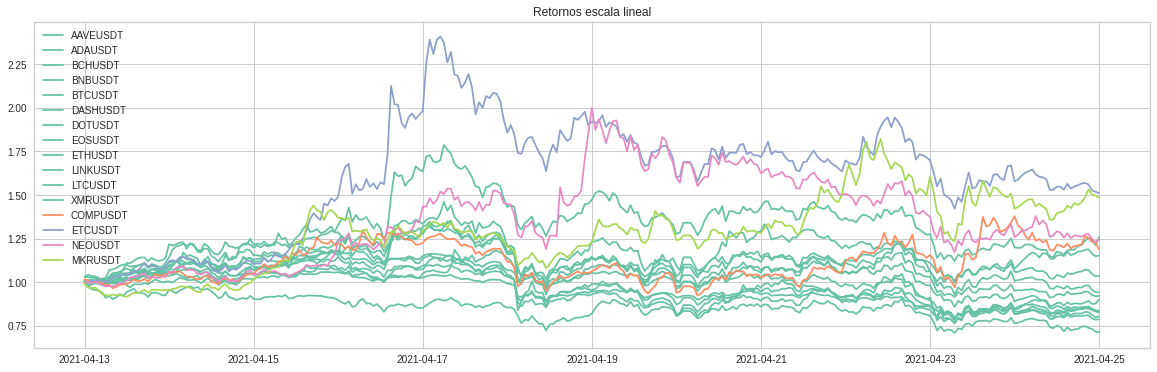

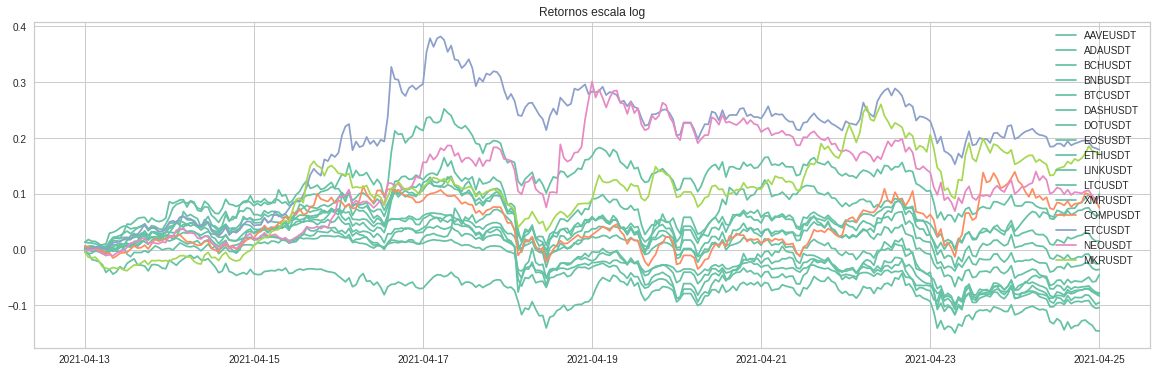

In [20]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(ms_p2_labels)):
    returns_cluster, returns_cluster_log = returns(df_p2.loc[:, df_ms.loc['periodo2'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")



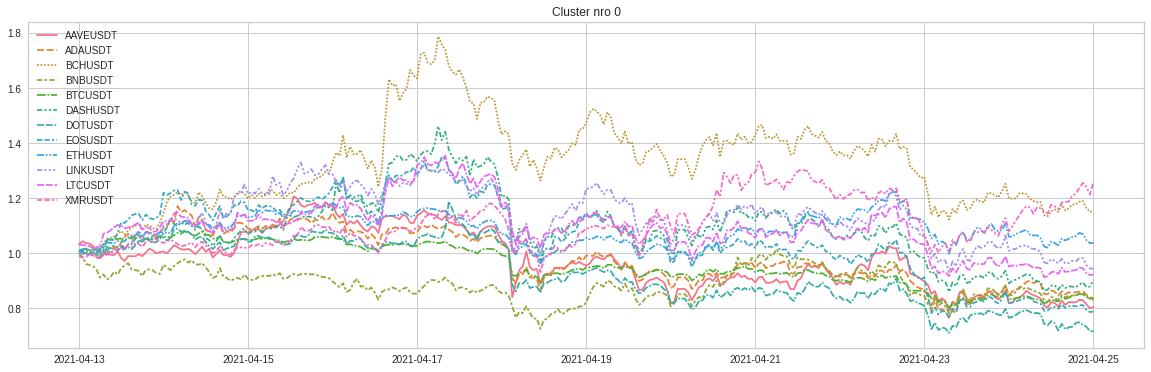

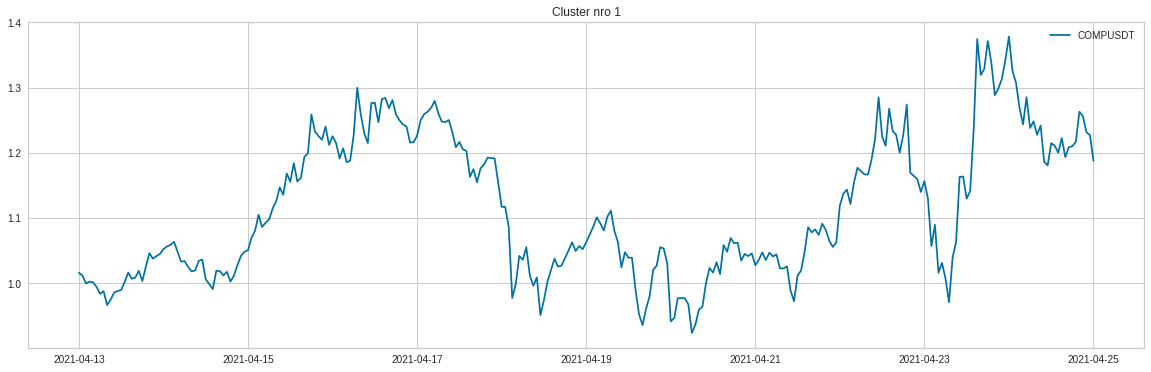

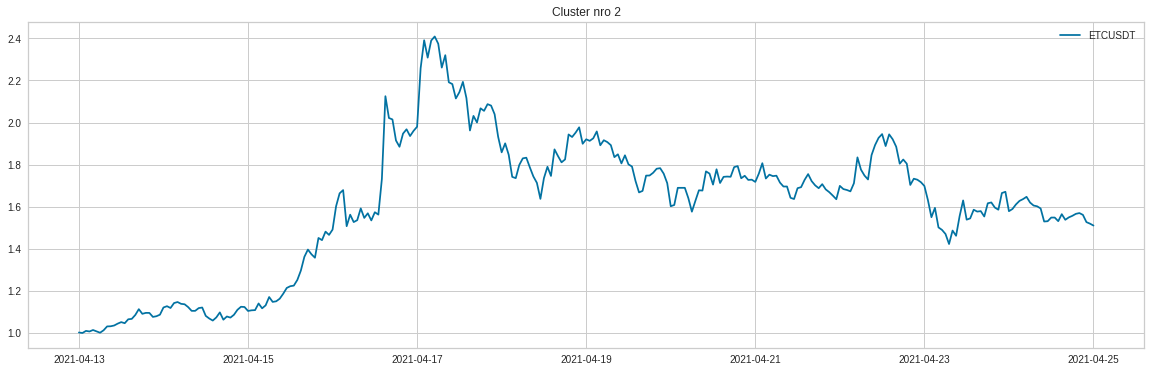

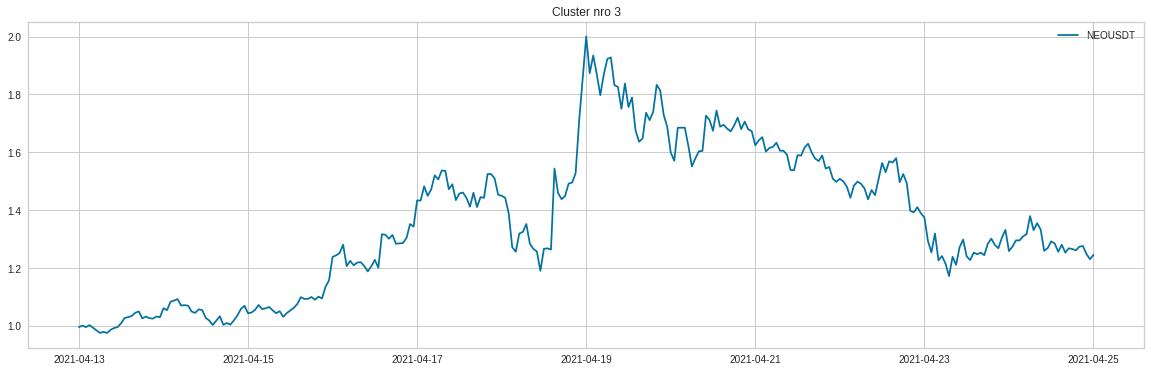

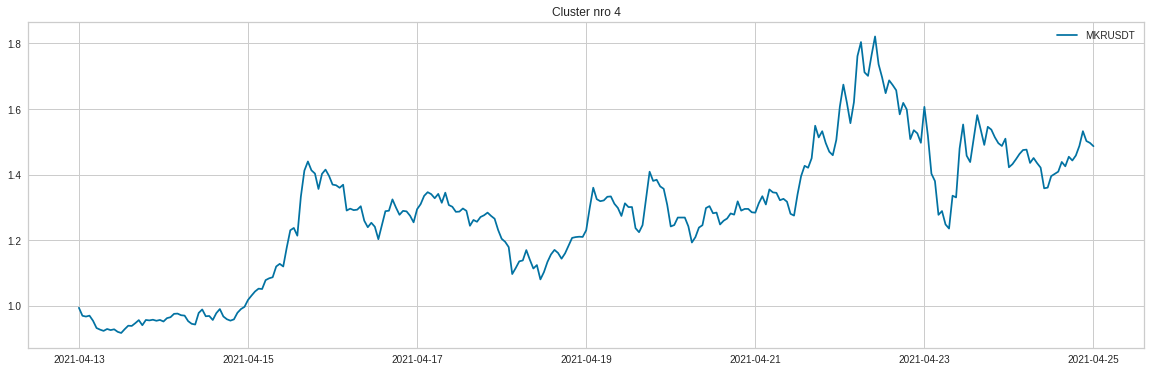

In [21]:
# Ploteamos cada cluster de forma agrupada
for c in np.unique(ms_p2_labels):
    fig = plt.figure(figsize=(20,6))
    returns_cluster,jaja = returns(df_p2.loc[:, df_ms.loc['periodo2'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

## K means

In [22]:
import warnings
warnings.filterwarnings('ignore')

### Periodo 1

In [21]:
# for c in range(2, 8):
#     #print(f'n_clusters = {c}')
#     m = TimeSeriesKMeans(n_clusters=c, random_state=10)
#     visualizer = SilhouetteVisualizer(m, colors='yellowbrick')
#     visualizer.fit(df_p1.T)        # Fit the data to the visualizer
#     visualizer.show()        # Finalize and render the figure

In [22]:
# for c in range(2, 8):
#     #print(f'n_clusters = {c}')
#     m = TimeSeriesKMeans(n_clusters=c, metric="softdtw", metric_params={"gamma": .01}, random_state=42)
#     visualizer = SilhouetteVisualizer(m, colors='yellowbrick')
#     visualizer.fit(df_p1.T)        # Fit the data to the visualizer
#     visualizer.show()        # Finalize and render the figure

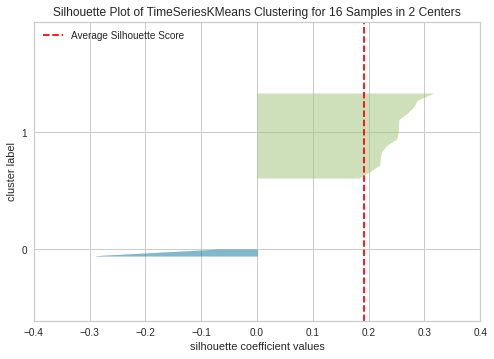

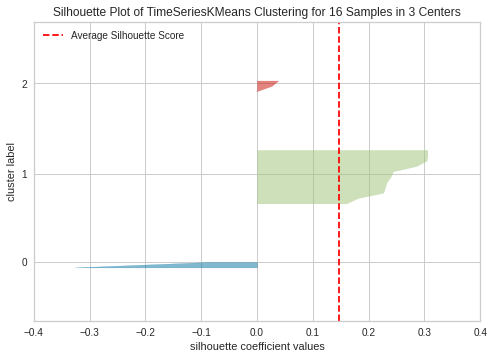

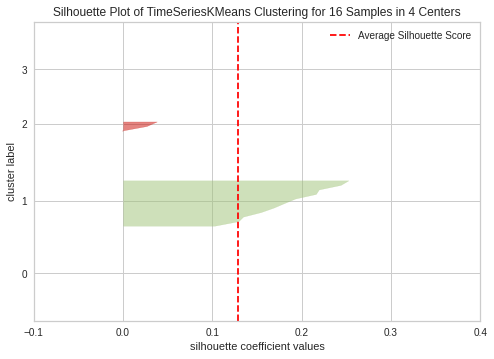

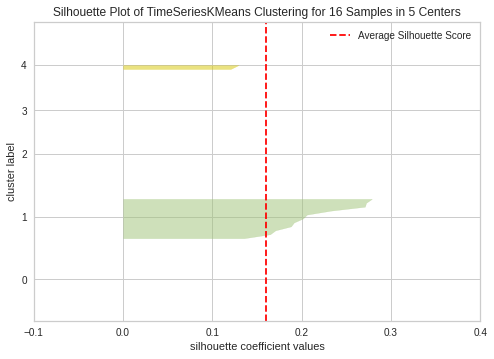

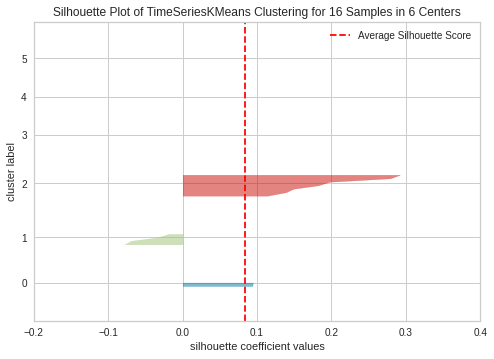

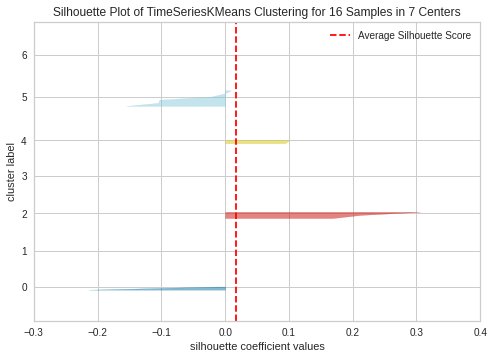

In [23]:
for c in range(2, 8):
    #print(f'n_clusters = {c}')
    m = TimeSeriesKMeans(n_clusters=c, n_init=2, metric="dtw", max_iter_barycenter=10, random_state=42)
    visualizer = SilhouetteVisualizer(m, colors='yellowbrick')
    visualizer.fit(df_p1.T)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

Si bien es difícil concluir el mejor número de clusters `c` debido a que el score promedio de silueta es en general bajo y cercano a cero, el mejor número para `c` sería 2 ó 5. Probaremos con `c=5` en base a lo observado con Mean Shift.

In [24]:
km = TimeSeriesKMeans(n_clusters=5, n_init=2, metric="dtw", max_iter_barycenter=10, random_state=42)
km_p1_labels = km.fit_predict(df_p1.T)

In [25]:
df_km = pd.DataFrame(columns=df.columns, index=['periodo1'], data=[km_p1_labels])

Cluster 0: ['MKRUSDT']
Cluster 1: ['BCHUSDT' 'BTCUSDT' 'DASHUSDT' 'DOTUSDT' 'EOSUSDT' 'ETCUSDT' 'ETHUSDT'
 'LINKUSDT' 'LTCUSDT' 'NEOUSDT' 'XMRUSDT']
Cluster 2: ['BNBUSDT']
Cluster 3: ['ADAUSDT']
Cluster 4: ['AAVEUSDT' 'COMPUSDT']


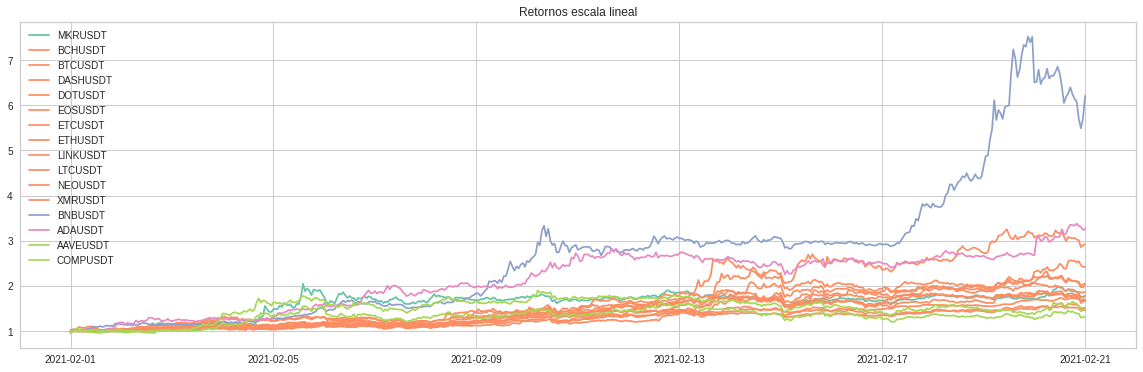

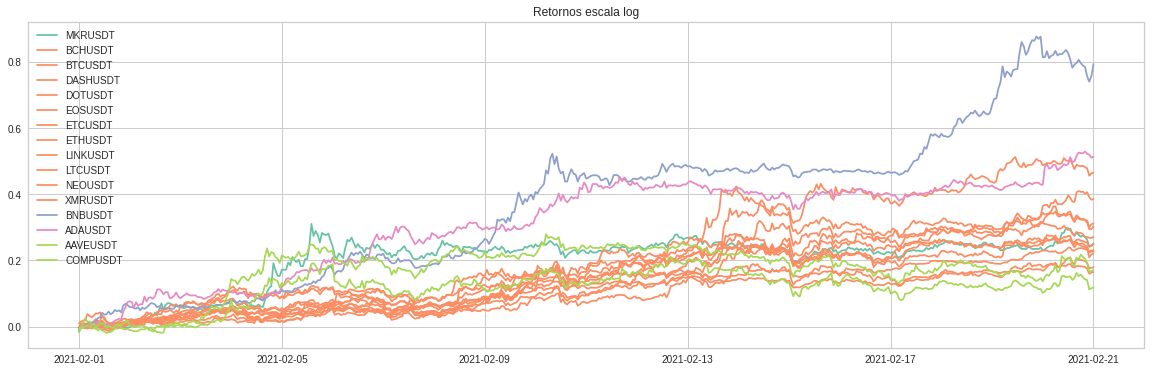

In [26]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(km_p1_labels)):
    returns_cluster, returns_cluster_log = returns(df_p1.loc[:, df_km.loc['periodo1'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")



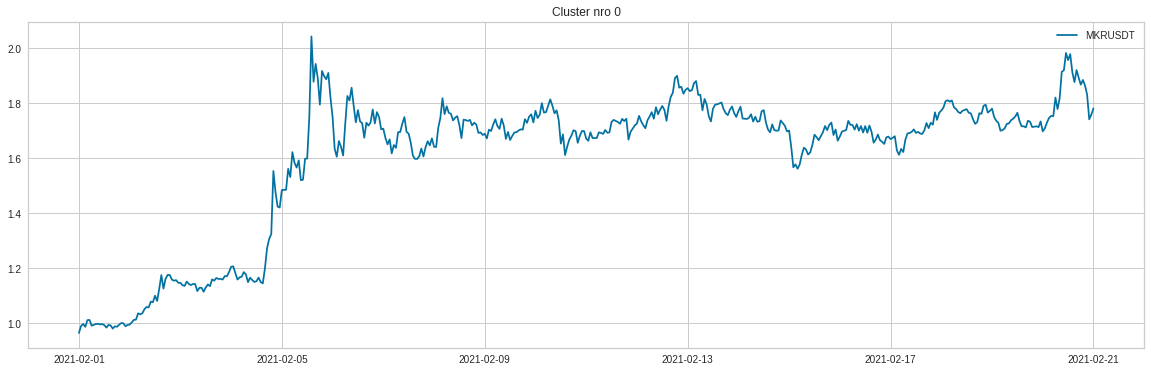

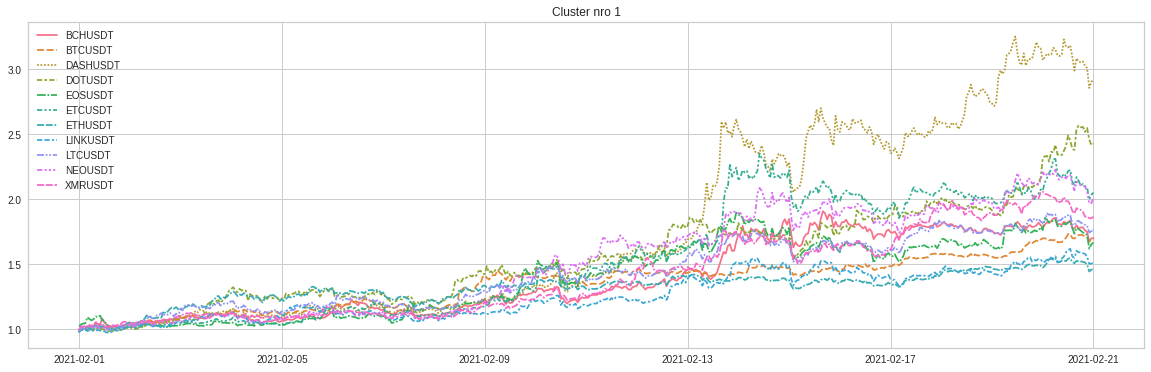

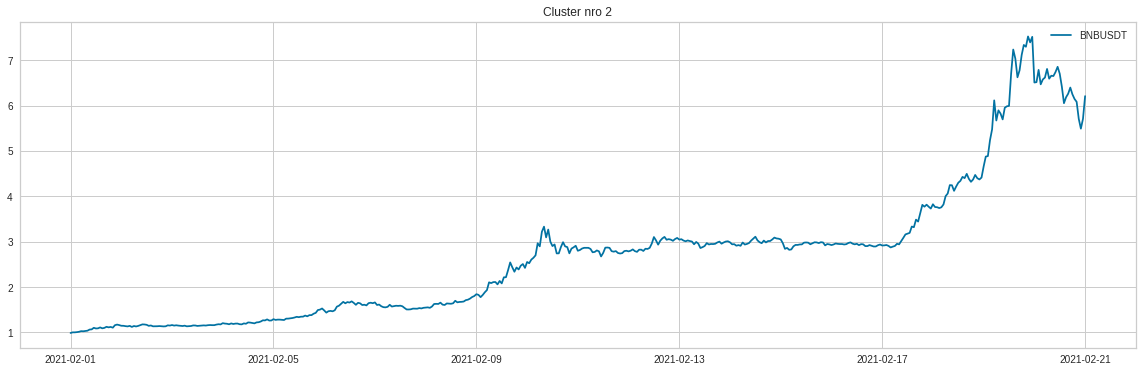

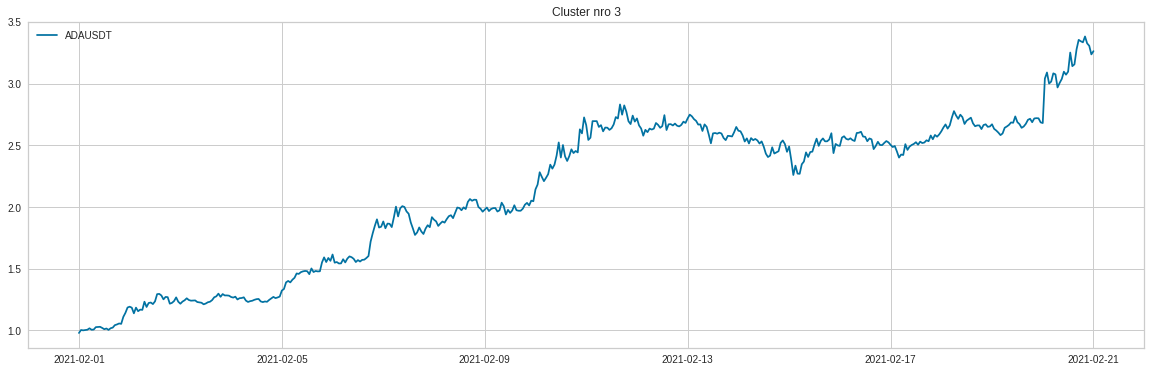

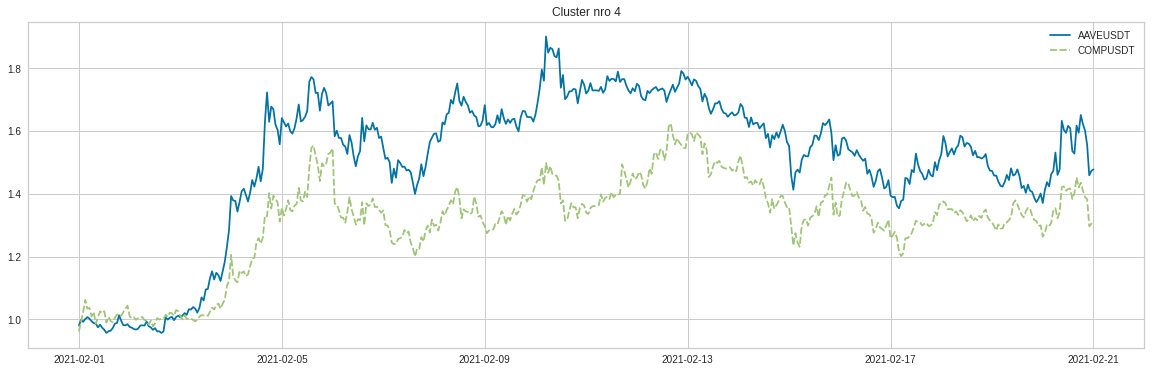

In [27]:
for c in np.unique(km_p1_labels):
    fig = plt.figure(figsize=(20,6))
    returns_cluster, _ = returns(df_p1.loc[:, df_km.loc['periodo1'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

### Periodo 2

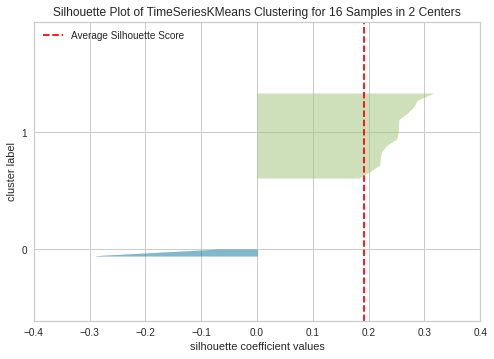

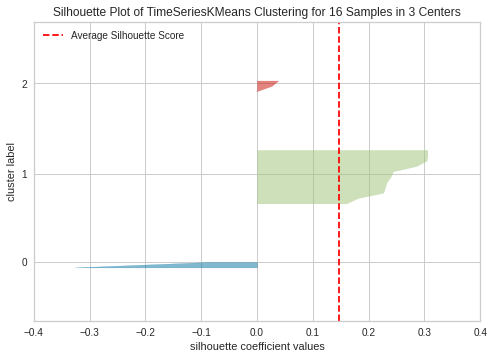

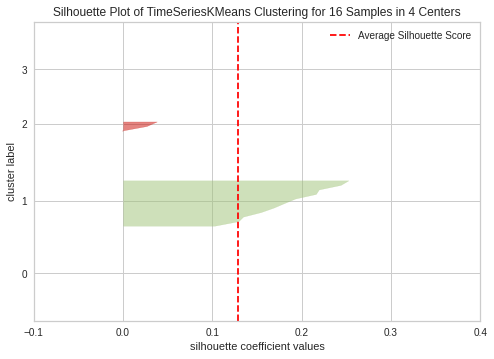

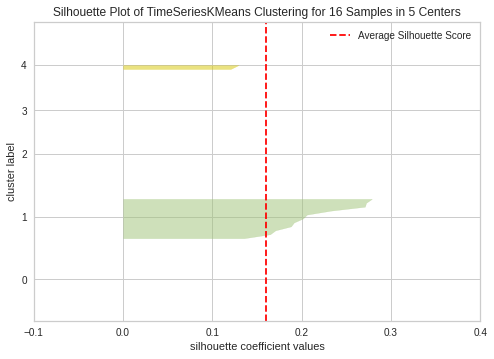

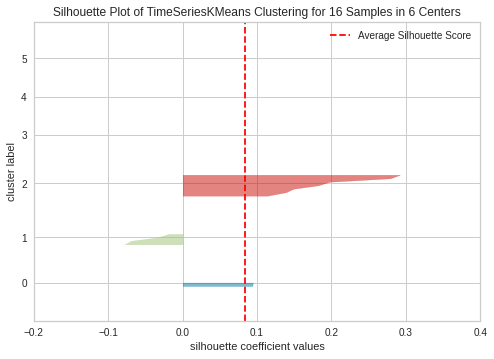

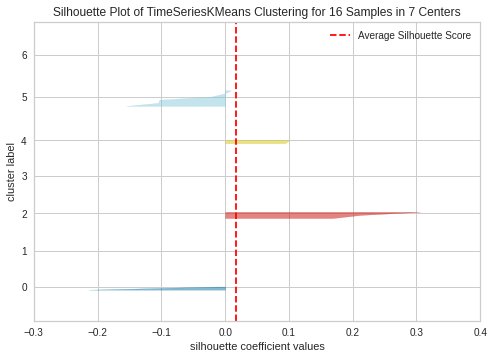

In [28]:
for c in range(2, 8):
    #print(f'n_clusters = {c}')
    m = TimeSeriesKMeans(n_clusters=c, n_init=2, metric="dtw", max_iter_barycenter=10, random_state=42)
    visualizer = SilhouetteVisualizer(m, colors='yellowbrick')
    visualizer.fit(df_p1.T)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

Si bien es difícil concluir el mejor número de clusters `c` debido a que el score promedio de silueta es en general bajo y cercano a cero, el mejor número para `c` sería 2 ó 5. Probaremos con `c=5` en base a lo observado con Mean Shift.

In [29]:
km = TimeSeriesKMeans(n_clusters=5, n_init=2, metric="dtw", max_iter_barycenter=10, random_state=42)
km_p2_labels = km.fit_predict(df_p2.T)

In [30]:
df_km = df_km.append(pd.Series(index=df.columns, data=km_p2_labels, name='periodo2'))

Cluster 0: ['MKRUSDT']
Cluster 1: ['BNBUSDT' 'COMPUSDT' 'XMRUSDT']
Cluster 2: ['ETCUSDT' 'NEOUSDT']
Cluster 3: ['AAVEUSDT' 'ADAUSDT' 'BTCUSDT' 'DOTUSDT' 'ETHUSDT' 'LINKUSDT' 'LTCUSDT']
Cluster 4: ['BCHUSDT' 'DASHUSDT' 'EOSUSDT']


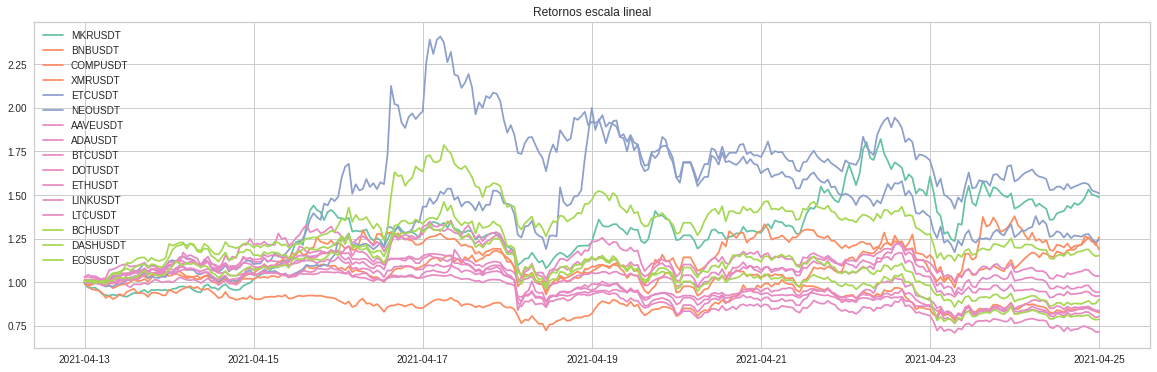

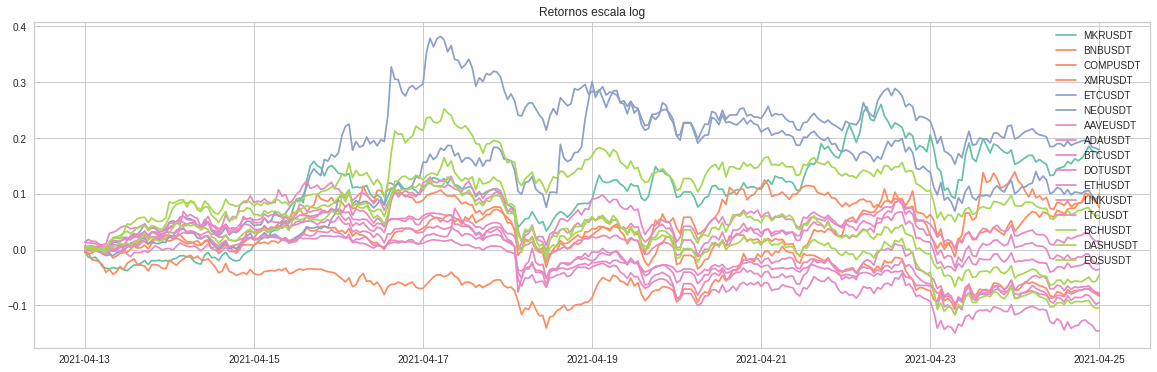

In [31]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(km_p2_labels)):
    returns_cluster, returns_cluster_log = returns(df_p2.loc[:, df_km.loc['periodo2'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")



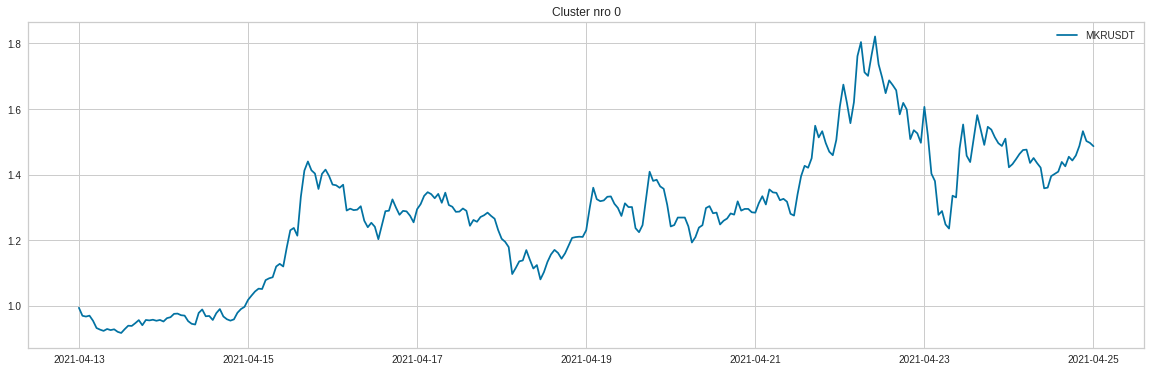

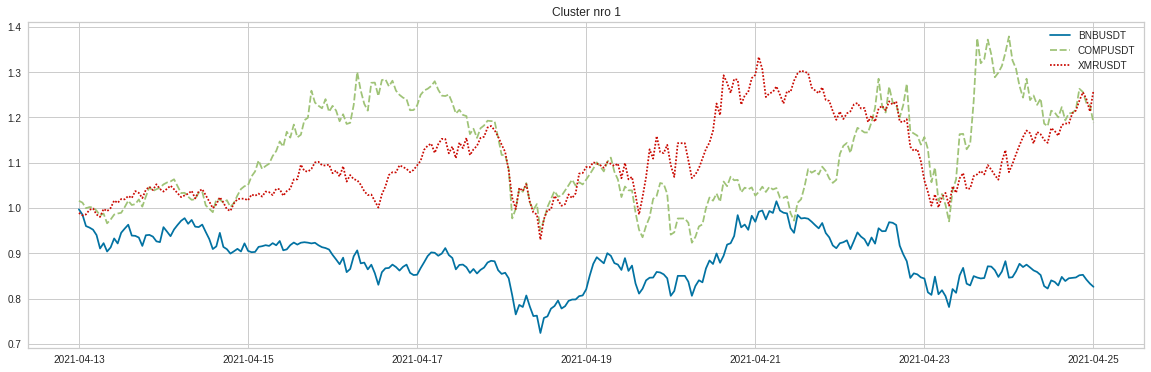

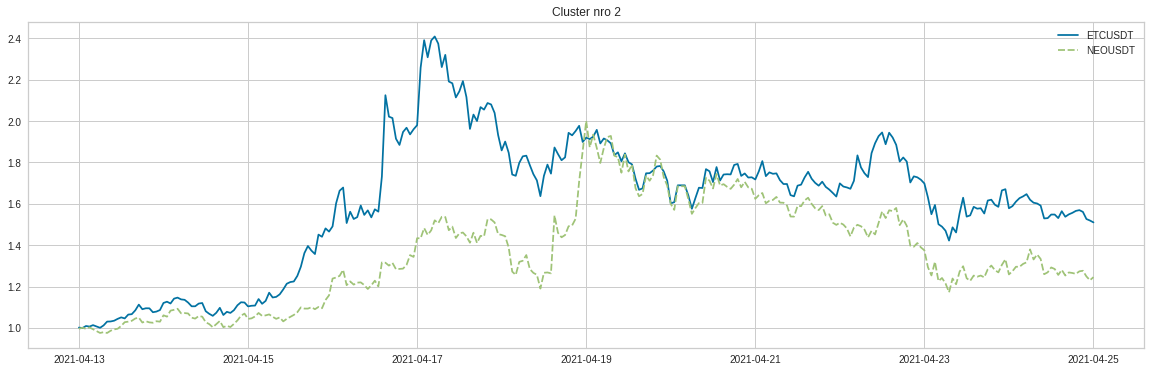

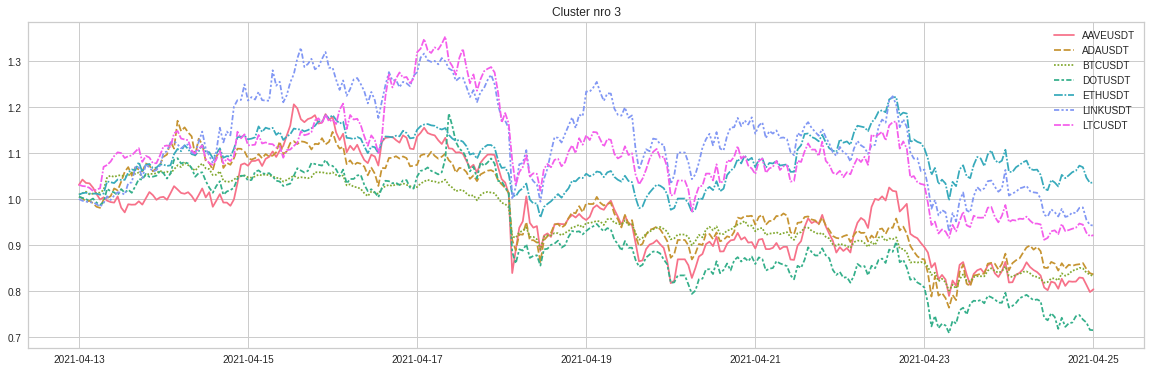

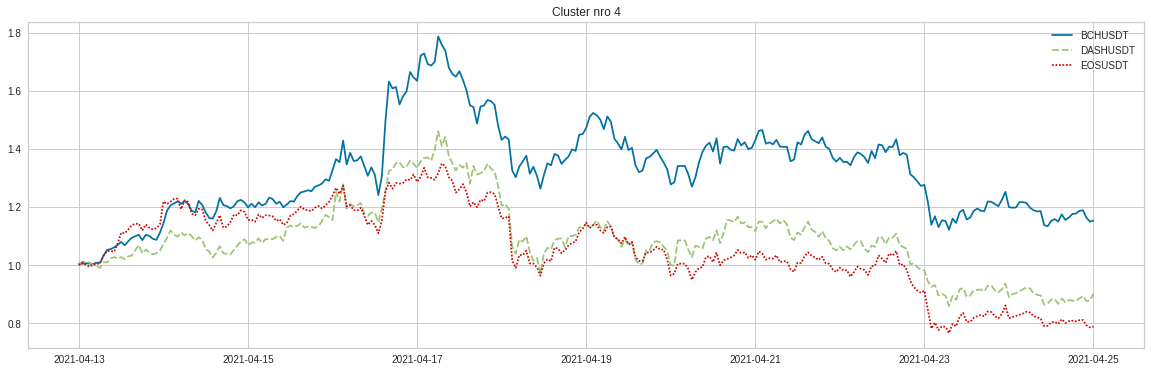

In [32]:
for c in np.unique(km_p2_labels):
    fig = plt.figure(figsize=(20,6))
    returns_cluster, _ = returns(df_p2.loc[:, df_km.loc['periodo2'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

## Clustering Jerárquico

### Periodo 1

In [33]:
from sklearn.cluster import AgglomerativeClustering

In [34]:
AC_p1 = AgglomerativeClustering(affinity='manhattan', linkage='complete', n_clusters=5)
AC_p1.fit(df_p1.T)
AC_p1.labels_

array([0, 3, 2, 4, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2])

In [35]:
df_ac = pd.DataFrame(columns=df.columns, index=['periodo1'], data=[AC_p1.labels_])

Cluster 0: ['AAVEUSDT' 'COMPUSDT' 'DOTUSDT']
Cluster 1: ['MKRUSDT']
Cluster 2: ['BCHUSDT' 'BTCUSDT' 'DASHUSDT' 'EOSUSDT' 'ETCUSDT' 'ETHUSDT' 'LINKUSDT'
 'LTCUSDT' 'NEOUSDT' 'XMRUSDT']
Cluster 3: ['ADAUSDT']
Cluster 4: ['BNBUSDT']


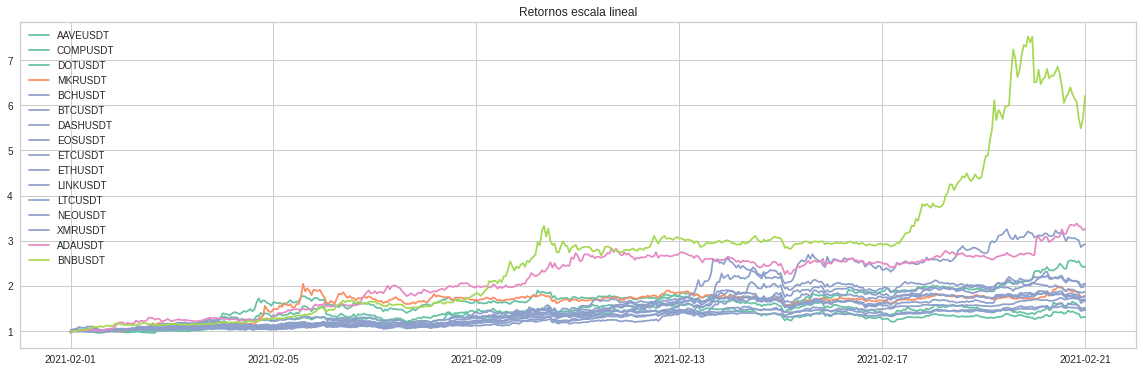

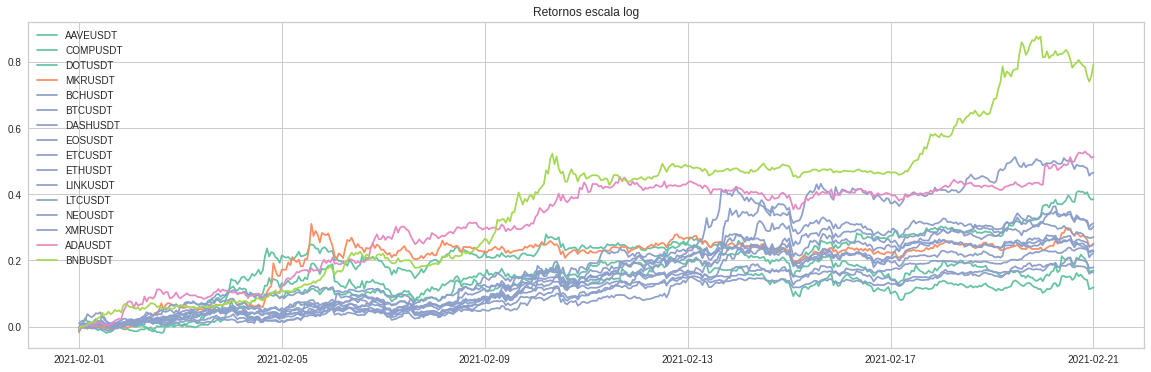

In [36]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(AC_p1.labels_)):
    returns_cluster, returns_cluster_log = returns(df_p1.loc[:, df_ac.loc['periodo1'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")

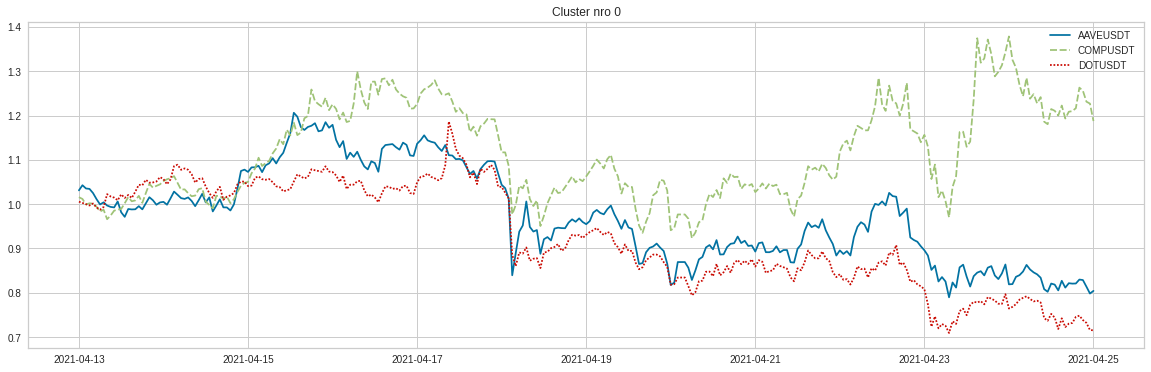

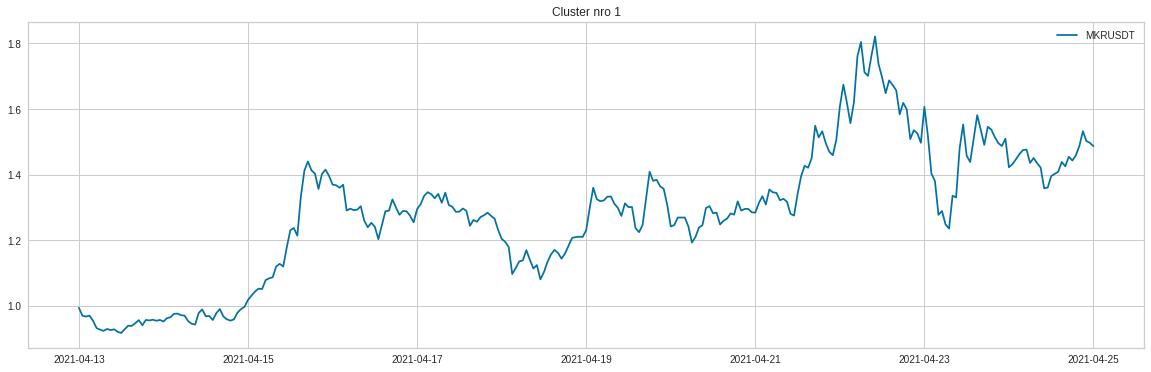

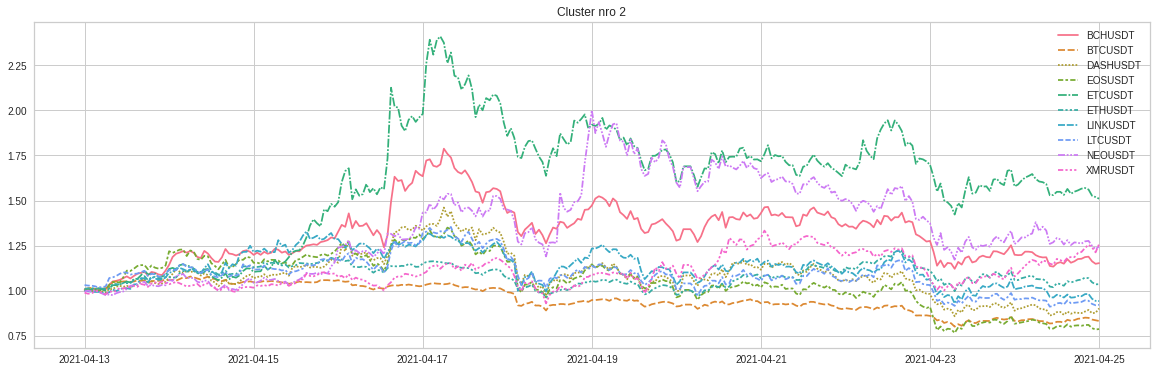

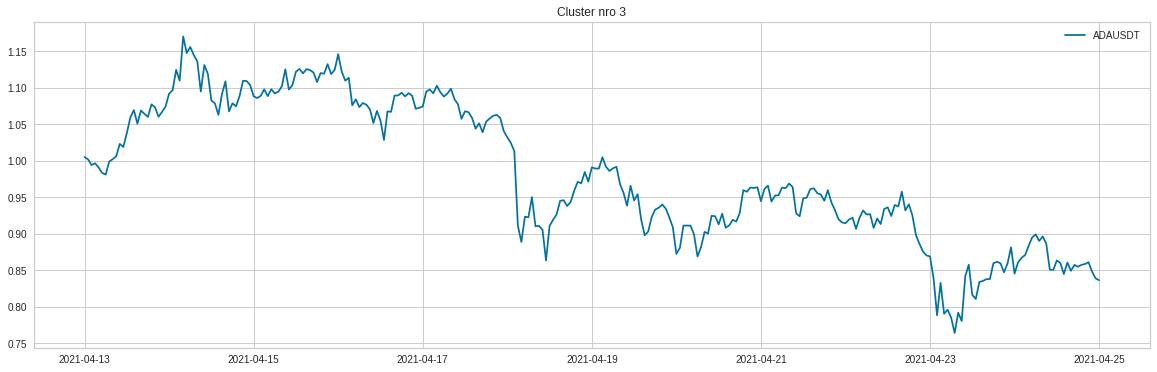

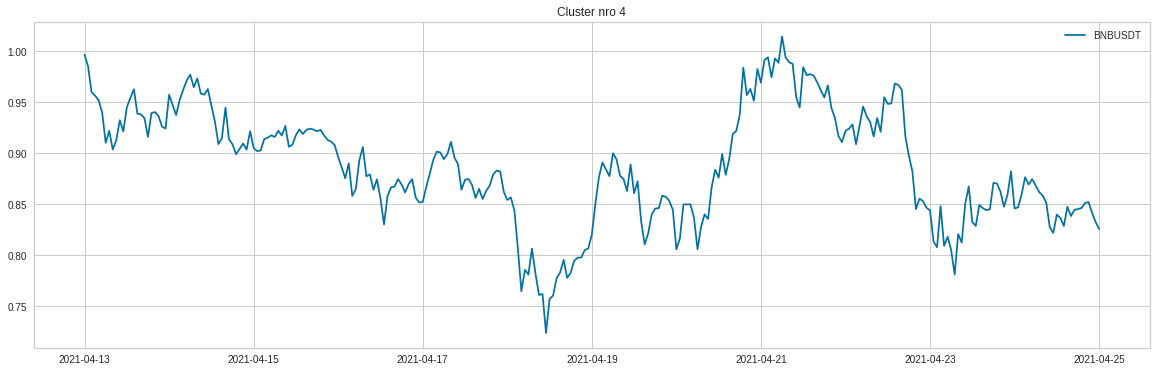

In [37]:
for c in np.unique(AC_p1.labels_):
    fig = plt.figure(figsize=(20,6))
    returns_cluster, _ = returns(df_p2.loc[:, df_ac.loc['periodo1'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

### Periodo 2

In [38]:
AC_p2 = AgglomerativeClustering(affinity='manhattan', linkage='complete', n_clusters=5)
AC_p2.fit(df_p2.T)
AC_p2.labels_

array([0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 3, 1, 0])

In [39]:
df_ac = df_ac.append(pd.Series(index=df.columns, data=AC_p2.labels_, name='periodo2'))
df_ac

AAVEUSDT_close_pct  ...  XMRUSDT_close_pct
periodo1                   0  ...                  2
periodo2                   0  ...                  0

[2 rows x 16 columns]

Cluster 0: ['AAVEUSDT' 'ADAUSDT' 'BCHUSDT' 'BNBUSDT' 'BTCUSDT' 'DASHUSDT' 'DOTUSDT'
 'EOSUSDT' 'ETHUSDT' 'LINKUSDT' 'LTCUSDT' 'XMRUSDT']
Cluster 1: ['NEOUSDT']
Cluster 2: ['ETCUSDT']
Cluster 3: ['MKRUSDT']
Cluster 4: ['COMPUSDT']


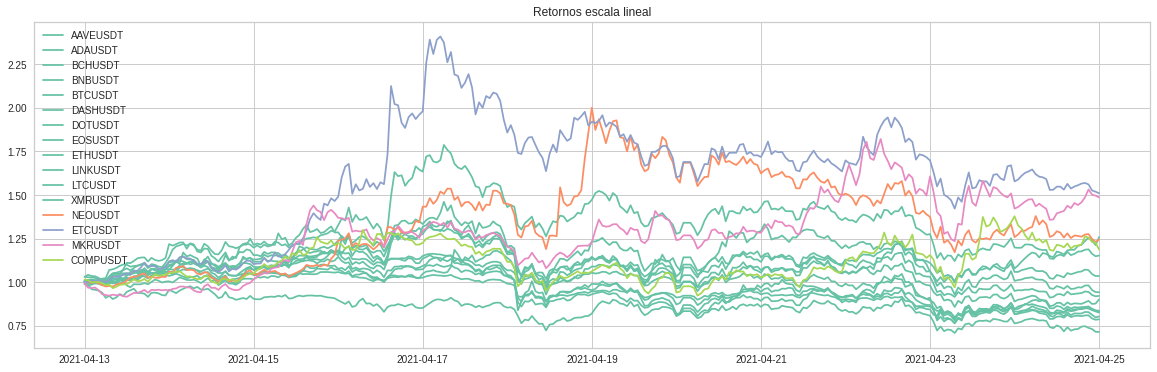

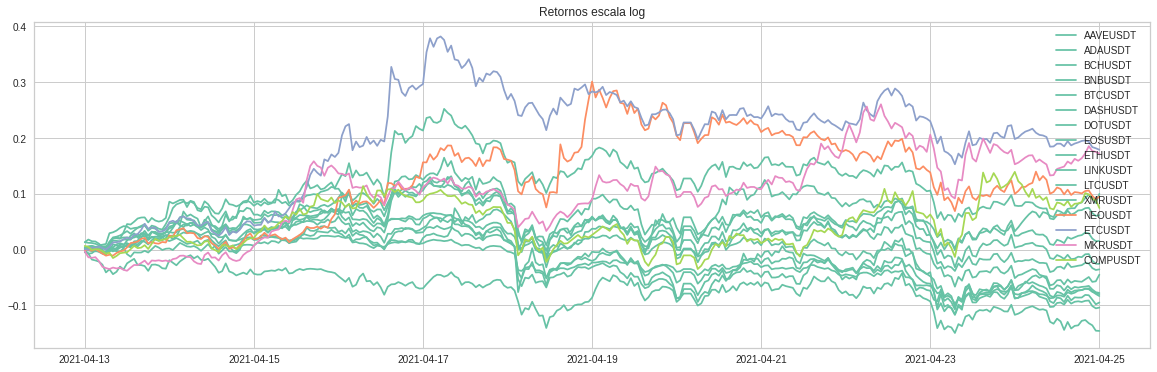

In [40]:
fig1, ax1 = plt.subplots(figsize=(20,6))
fig2, ax2 = plt.subplots(figsize=(20,6))

colors = sns.color_palette("Set2")
for col, clu in enumerate(np.unique(AC_p2.labels_)):
    returns_cluster, returns_cluster_log = returns(df_p2.loc[:, df_ac.loc['periodo2'] == clu])

    print(f'Cluster {clu}: {returns_cluster.columns.values}')
    
    sns.lineplot(data=returns_cluster, ax=ax1, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax1.title.set_text("Retornos escala lineal")
    
    sns.lineplot(data=returns_cluster_log, ax=ax2, 
                     palette=sns.color_palette([colors[col]], len(returns_cluster.columns)), 
                     dashes=False)
    ax2.title.set_text("Retornos escala log")

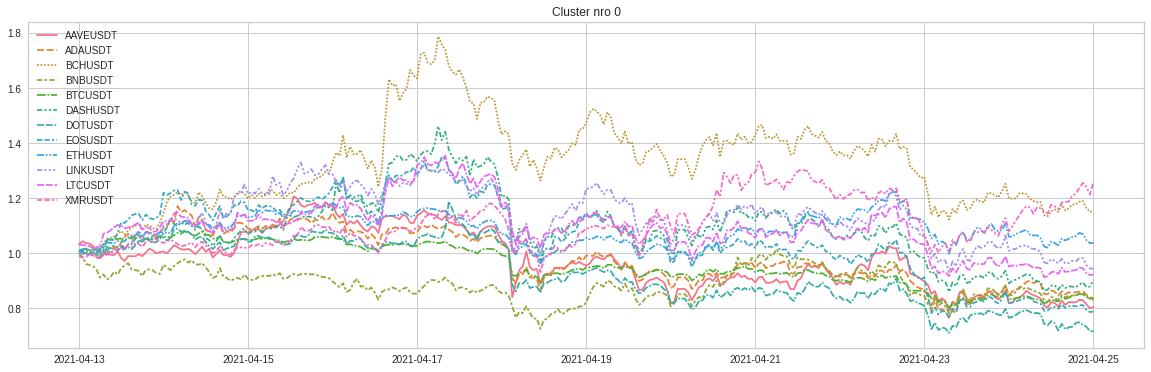

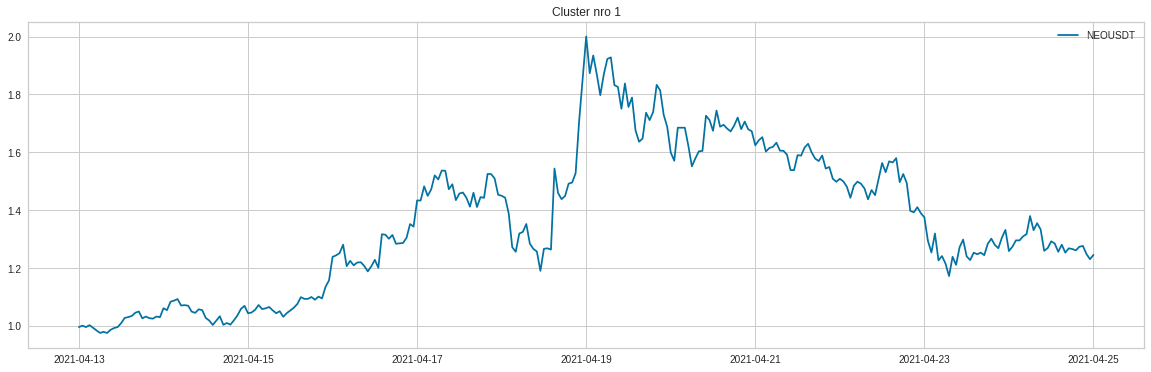

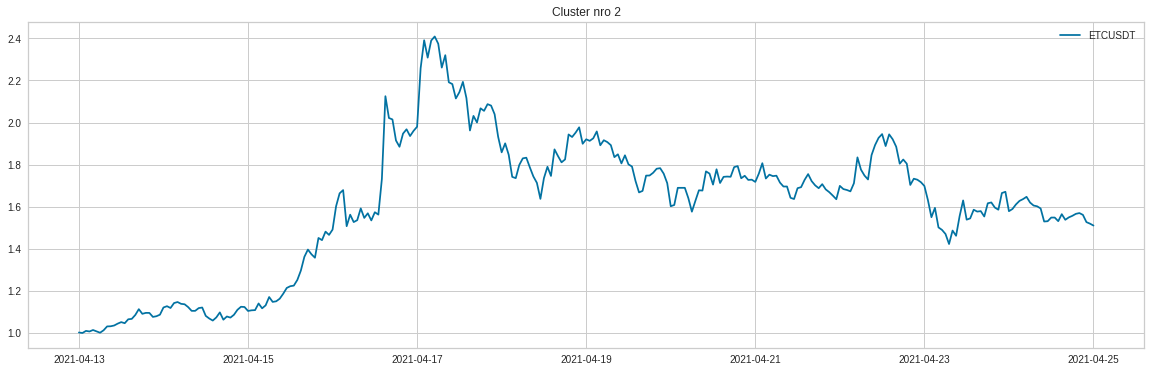

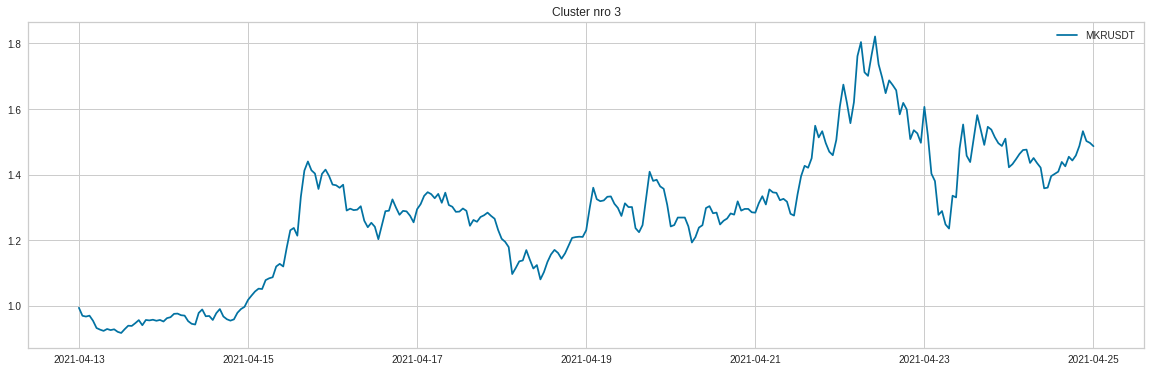

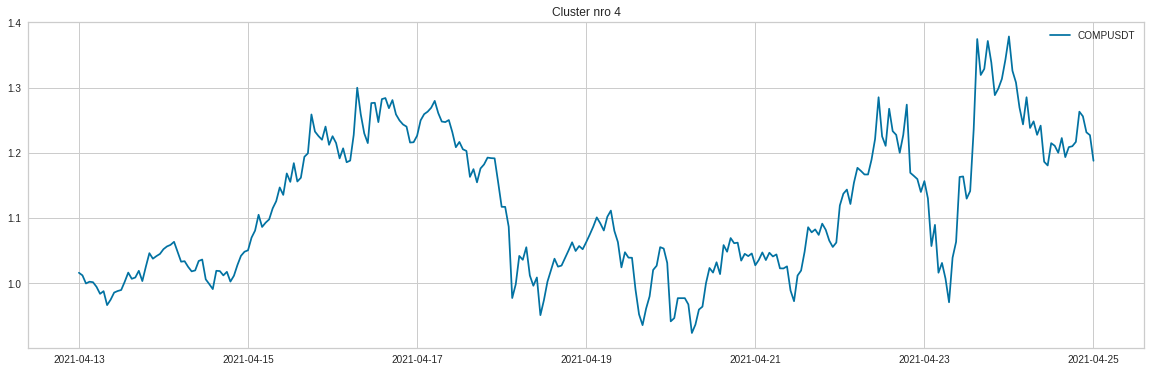

In [41]:
for c in np.unique(AC_p2.labels_):
    fig = plt.figure(figsize=(20,6))
    returns_cluster, _ = returns(df_p2.loc[:, df_ac.loc['periodo2'] == c])
    sns.lineplot(data=returns_cluster)
    plt.title(f'Cluster nro {c}')

# Parte 2

## Tasas de rendimiento

### Periodo 1

In [42]:
df_p1_pca = df_p1.T.copy()

Vamos a optar por 3 componentes principales de forma de poder visualizar todos ellos en un gráfico.

In [43]:
pca=decomposition.PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(df_p1_pca) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_p1_pca) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.1841307  0.16607046 0.09863422]
proporción de varianza por componente acumulada:  [0.1841307  0.35020115 0.44883538]
tamaño de los datos:  (16, 3)


In [44]:
fig = px.scatter_3d(
    X_projected, x=0, y=1, z=2, color=[i[:-10] for i in df_p1.columns],
    title=f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(showlegend=False)
fig.show(renderer="colab")

Utilizando el PCA sin escalar las variables vemos que las crypto se agrupan en forma similar a las distintas técnicas de clustering anteriormente utilizadas. BNB queda con la mayor diferenciación al resto, COMP y AAVE forman un pequeño grupo y ADA y MKR quedan diferenciados también cada uno por su cuenta. 

Un punto a no subestimar es que con estos componentes solo se explica un 45% de la varianza.

### Periodo 2

In [45]:
df_p2_pca = df_p2.T.copy()

In [46]:
pca=decomposition.PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(df_p2_pca) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_p2_pca) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.21673067 0.16709767 0.1337125 ]
proporción de varianza por componente acumulada:  [0.21673067 0.38382833 0.51754084]
tamaño de los datos:  (16, 3)


In [47]:
fig = px.scatter_3d(
    X_projected, x=0, y=1, z=2, color=[i[:-10] for i in df_p2.columns],
    title=f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(showlegend=False)
fig.show(renderer="colab")

Cuando analizamos el período bajista, llegamos a conclusiones similares a las del período alcista: similutud entre PCA y clustering y baja representatividad de la varianza, que en este caso mejora hasta el 52%.


## Tasas de rendimiento estandarizadas

### Periodo 1


In [48]:
df_p1_pca_scaled = preprocessing.StandardScaler().fit_transform(df_p1.T)

In [49]:
pca=decomposition.PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(df_p1_pca_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_p1_pca_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.14479445 0.13540146 0.09959245]
proporción de varianza por componente acumulada:  [0.14479445 0.2801959  0.37978835]
tamaño de los datos:  (16, 3)


In [50]:
fig = px.scatter_3d(
    X_projected, x=0, y=1, z=2, color=[i[:-10] for i in df_p1.columns],
    title=f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(showlegend=False)
fig.show(renderer="colab")

Escalando las variables, si bien se mantiene la separación entre clusters, en algunos casos es menos clara, sumado a que la varianza total explicada disminuye.

### Periodo 2

In [51]:
df_p2_pca_scaled = preprocessing.StandardScaler().fit_transform(df_p2.T)

In [52]:
pca=decomposition.PCA(n_components=3) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(df_p2_pca_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_p2_pca_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.16438993 0.14394996 0.10346019]
proporción de varianza por componente acumulada:  [0.16438993 0.30833989 0.41180008]
tamaño de los datos:  (16, 3)


In [53]:
fig = px.scatter_3d(
    X_projected, x=0, y=1, z=2, color=[i[:-10] for i in df_p2.columns],
    title=f'Total Explained Variance: {pca.explained_variance_ratio_.sum() * 100:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(showlegend=False)
fig.show(renderer="colab")

Las conclusiones para este período van en línea con el período anterior, aunque reforzamos el hecho de que la separación entre clusters empeora. COMP, que en todos los clusters se situaba en el grupo más grande, aquí aparece separado del resto.